<a href="https://colab.research.google.com/github/Ddhawan2003/FplAnalytics/blob/main/PLWins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

In [3]:
matches = pd.read_csv('matches (3).csv')

In [41]:
matches.head()

,Unnamed: 0,date,time,round,day,venue,result,gf,ga,opponent,...,fk,pk,pkatt,season,team,target,venue_code,opp_code,hour,day_code
0,1,2021-08-15,16:30,Matchweek 1,Sun,Away,L,0.0,1.0,Tottenham,...,1.0,0.0,0.0,2022,Manchester City,0,0,18,16,6
1,2,2021-08-21,15:00,Matchweek 2,Sat,Home,W,5.0,0.0,Norwich City,...,1.0,0.0,0.0,2022,Manchester City,1,1,15,15,5
2,3,2021-08-28,12:30,Matchweek 3,Sat,Home,W,5.0,0.0,Arsenal,...,0.0,0.0,0.0,2022,Manchester City,1,1,0,12,5
3,4,2021-09-11,15:00,Matchweek 4,Sat,Away,W,1.0,0.0,Leicester City,...,0.0,0.0,0.0,2022,Manchester City,1,0,10,15,5
4,6,2021-09-18,15:00,Matchweek 5,Sat,Home,D,0.0,0.0,Southampton,...,1.0,0.0,0.0,2022,Manchester City,0,1,17,15,5


In [5]:
del matches["comp"]
del matches["notes"]
matches["date"] = pd.to_datetime(matches["date"])
matches["target"] = (matches["result"] == "W").astype("int")

In [6]:
matches["venue_code"] = matches["venue"].astype("category").cat.codes
matches["opp_code"] = matches["opponent"].astype("category").cat.codes
matches["hour"] = matches["time"].str.replace(":.+", "", regex=True).astype("int")
matches["day_code"] = matches["date"].dt.dayofweek

In [17]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=50, min_samples_split=10, random_state=42)
train = matches[matches["date"] < '2022-01-01']
test = matches[matches["date"] > '2022-01-01']
predictors = ["venue_code", "opp_code", "hour", "day_code"]
rf.fit(train[predictors], train["target"])
preds = rf.predict(test[predictors])
from sklearn.metrics import accuracy_score
error = accuracy_score(test["target"], preds)
error

0.6268115942028986

In [18]:
combined = pd.DataFrame(dict(actual=test["target"], predicted=preds))
pd.crosstab(index=combined["actual"], columns=combined["predicted"])

predicted,0,1
actual,,
0,147,25
1,78,26


In [19]:
from sklearn.metrics import precision_score

precision_score(test["target"], preds)

0.5098039215686274

In [20]:
grouped_matches = matches.groupby("team")
group = grouped_matches.get_group("Manchester City").sort_values("date")
def rolling_averages(group, cols, new_cols):
    group = group.sort_values("date")
    rolling_stats = group[cols].rolling(3, closed='left').mean()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    return group
cols = ["gf", "ga", "sh", "sot", "dist", "fk", "pk", "pkatt"]
new_cols = [f"{c}_rolling" for c in cols]

rolling_averages(group, cols, new_cols)

,Unnamed: 0,date,time,round,day,venue,result,gf,ga,opponent,...,hour,day_code,gf_rolling,ga_rolling,sh_rolling,sot_rolling,dist_rolling,fk_rolling,pk_rolling,pkatt_rolling
632,5,2020-10-17,17:30,Matchweek 5,Sat,Home,W,1.0,0.0,Arsenal,...,17,5,2.000000,2.333333,17.333333,4.666667,18.900000,1.333333,0.333333,0.333333
633,7,2020-10-24,12:30,Matchweek 6,Sat,Away,D,1.0,1.0,West Ham,...,12,5,1.333333,2.000000,17.333333,3.666667,17.733333,0.666667,0.000000,0.000000
634,9,2020-10-31,12:30,Matchweek 7,Sat,Away,W,1.0,0.0,Sheffield Utd,...,12,5,1.000000,0.666667,16.666667,4.333333,18.233333,0.666667,0.000000,0.000000
635,11,2020-11-08,16:30,Matchweek 8,Sun,Home,D,1.0,1.0,Liverpool,...,16,6,1.000000,0.333333,14.333333,6.666667,18.466667,1.000000,0.000000,0.000000
636,12,2020-11-21,17:30,Matchweek 9,Sat,Away,L,0.0,2.0,Tottenham,...,17,5,1.000000,0.666667,12.000000,5.666667,19.366667,1.000000,0.000000,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,42,2022-03-14,20:00,Matchweek 29,Mon,Away,D,0.0,0.0,Crystal Palace,...,20,0,2.333333,1.333333,19.000000,7.000000,15.366667,0.333333,0.333333,0.333333
29,44,2022-04-02,15:00,Matchweek 31,Sat,Away,W,2.0,0.0,Burnley,...,15,5,1.666667,0.333333,18.333333,7.333333,16.000000,0.333333,0.000000,0.000000
30,46,2022-04-10,16:30,Matchweek 32,Sun,Home,D,2.0,2.0,Liverpool,...,16,6,2.000000,0.333333,20.000000,6.666667,16.133333,0.333333,0.000000,0.000000
31,49,2022-04-20,20:00,Matchweek 30,Wed,Home,W,3.0,0.0,Brighton,...,20,2,1.333333,0.666667,15.666667,4.666667,16.700000,0.333333,0.000000,0.000000


In [23]:
matches_rolling = matches.groupby("team").apply(lambda x: rolling_averages(x, cols, new_cols))
matches_rolling = matches_rolling.droplevel('team')
matches_rolling.index = range(matches_rolling.shape[0])

/tmp/ipython-input-23-3498062678.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  matches_rolling = matches.groupby("team").apply(lambda x: rolling_averages(x, cols, new_cols))


In [24]:
def make_predictions(data, predictors):
    train = data[data["date"] < '2022-01-01']
    test = data[data["date"] > '2022-01-01']
    rf.fit(train[predictors], train["target"])
    preds = rf.predict(test[predictors])
    combined = pd.DataFrame(dict(actual=test["target"], predicted=preds), index=test.index)
    error = precision_score(test["target"], preds)
    return combined, error

In [26]:
combined, error = make_predictions(matches_rolling, predictors + new_cols)
error

0.5357142857142857

In [27]:
combined = combined.merge(matches_rolling[["date", "team", "opponent", "result"]], left_index=True, right_index=True)

In [28]:
class MissingDict(dict):
    __missing__ = lambda self, key: key

map_values = {"Brighton and Hove Albion": "Brighton", "Manchester United": "Manchester Utd", "Newcastle United": "Newcastle Utd", "Tottenham Hotspur": "Tottenham", "West Ham United": "West Ham", "Wolverhampton Wanderers": "Wolves"}
mapping = MissingDict(**map_values)
combined["new_team"] = combined["team"].map(mapping)
merged = combined.merge(combined, left_on=["date", "new_team"], right_on=["date", "opponent"])

In [30]:
merged[(merged["predicted_x"] == 1) & (merged["predicted_y"] ==0)]["actual_x"].value_counts()

,count
actual_x,
1,25
0,20


In [32]:
merged[(merged["predicted_x"] == 1) & (merged["predicted_y"] ==1)]["actual_x"]

,actual_x
5,1
24,0
53,1
78,1
129,0
142,1
156,0
170,0
217,1
218,0


In [33]:
both_win = merged[(merged["predicted_x"] == 1) & (merged["predicted_y"] == 1)]

In [35]:
both_win[["date", "team_x", "opponent_x", "predicted_x", "predicted_y", "actual_x", "actual_y", "result_x", "result_y"]]

,date,team_x,opponent_x,predicted_x,predicted_y,actual_x,actual_y,result_x,result_y
5,2022-03-13,Arsenal,Leicester City,1,1,1,0,W,L
24,2022-04-09,Aston Villa,Tottenham,1,1,0,1,L,W
53,2022-04-16,Brighton and Hove Albion,Tottenham,1,1,1,0,W,L
78,2022-03-13,Chelsea,Newcastle Utd,1,1,1,0,W,L
129,2022-03-13,Leicester City,Arsenal,1,1,0,1,L,W
142,2022-03-06,Manchester City,Manchester Utd,1,1,1,0,W,L
156,2022-03-06,Manchester United,Manchester City,1,1,0,1,L,W
170,2022-03-13,Newcastle United,Chelsea,1,1,0,1,L,W
217,2022-04-09,Tottenham Hotspur,Aston Villa,1,1,1,0,W,L
218,2022-04-16,Tottenham Hotspur,Brighton,1,1,0,1,L,W


In [36]:
def get_match_features(df):
    df = df.sort_values("date")
    rolling_features = [f"{col}_rolling" for col in ["gf", "ga", "sh", "sot", "dist", "fk", "pk", "pkatt"]]

    # Use only rows where both teams have rolling stats
    df = df.dropna(subset=rolling_features)

    matches = []
    for date in df["date"].unique():
        day_matches = df[df["date"] == date]
        teams = set(day_matches["team"])
        for team in teams:
            row = day_matches[day_matches["team"] == team]
            opp = row["opponent"].values[0]
            opp_row = day_matches[day_matches["team"] == opp]
            if not opp_row.empty:
                match = {
                    "date": date,
                    "team": team,
                    "opponent": opp,
                    "target": row["target"].values[0],
                }
                for col in rolling_features:
                    match[f"team_{col}"] = row[col].values[0]
                    match[f"opp_{col}"] = opp_row[col].values[0]
                matches.append(match)
    return pd.DataFrame(matches)

In [37]:
match_data = get_match_features(matches_rolling)
match_data = match_data.dropna()
train = match_data[match_data["date"] < '2022-01-01']
test = match_data[match_data["date"] > '2022-01-01']

predictors = [col for col in match_data.columns if col.startswith("team_") or col.startswith("opp_")]

rf.fit(train[predictors], train["target"])
preds = rf.predict(test[predictors])
accuracy_score(test["target"], preds)

0.5747126436781609

In [38]:
results = test.copy()
results["predicted"] = preds
results = results[["date", "team", "opponent", "target", "predicted"]]
results["result"] = results["target"].map({1: "Win", 0: "Not Win"})
results["predicted_result"] = results["predicted"].map({1: "Win", 0: "Not Win"})
results.head()

,date,team,opponent,target,predicted,result,predicted_result
628,2022-01-02,Burnley,Leeds United,0,0,Not Win,Not Win
629,2022-01-02,Leeds United,Burnley,1,0,Win,Not Win
630,2022-01-02,Aston Villa,Brentford,0,0,Not Win,Not Win
631,2022-01-02,Brentford,Aston Villa,1,0,Win,Not Win
632,2022-01-02,Brighton and Hove Albion,Everton,1,0,Win,Not Win


In [39]:
from sklearn.metrics import accuracy_score, precision_score, classification_report

accuracy = accuracy_score(test["target"], preds)
precision = precision_score(test["target"], preds)

print(f"Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(classification_report(test["target"], preds))

Accuracy: 57.47%
Precision: 48.28%
              precision    recall  f1-score   support

           0       0.59      0.85      0.70       101
           1       0.48      0.19      0.27        73

    accuracy                           0.57       174
   macro avg       0.54      0.52      0.49       174
weighted avg       0.55      0.57      0.52       174



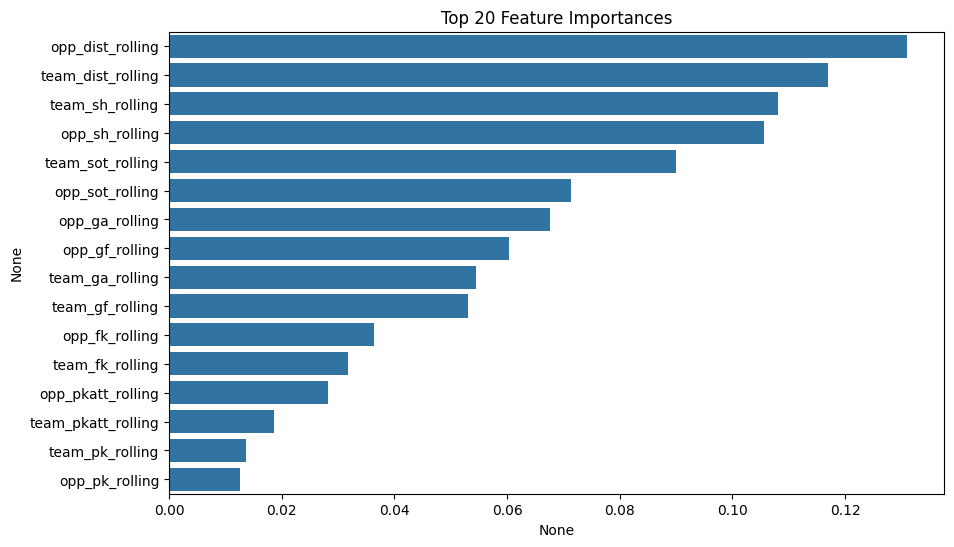

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance = pd.Series(rf.feature_importances_, index=predictors)
top_features = feature_importance.sort_values(ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(x=top_features, y=top_features.index)
plt.title("Top 20 Feature Importances")
plt.show()

In [44]:
top_features

,0
opp_dist_rolling,0.131003
team_dist_rolling,0.116881
team_sh_rolling,0.108121
opp_sh_rolling,0.105664
team_sot_rolling,0.090023
opp_sot_rolling,0.071389
opp_ga_rolling,0.067701
opp_gf_rolling,0.060292
team_ga_rolling,0.054530
team_gf_rolling,0.053024


In [46]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess
matches = pd.read_csv("matches (3).csv")
matches["date"] = pd.to_datetime(matches["date"])
matches["target"] = (matches["result"] == "W").astype("int")
matches["venue_code"] = matches["venue"].astype("category").cat.codes
matches["opp_code"] = matches["opponent"].astype("category").cat.codes
matches["hour"] = matches["time"].str.replace(":.+", "", regex=True).astype("int")
matches["day_code"] = matches["date"].dt.dayofweek
matches["is_home"] = (matches["venue"] == "Home").astype("int")

# Add form (rolling points)
def add_form(group):
    group = group.sort_values("date")
    group["points"] = 3 * (group["result"] == "W") + 1 * (group["result"] == "D")
    group["form_rolling"] = group["points"].rolling(3, closed='left').mean()
    return group

matches = matches.groupby("team").apply(add_form).droplevel('team').reset_index(drop=True)

# Add rolling averages
rolling_cols = ["gf", "ga", "sh", "sot", "dist", "fk", "pk", "pkatt"]
rolling_features = [f"{c}_rolling" for c in rolling_cols]

def add_rolling_avgs(group):
    group = group.sort_values("date")
    rolling = group[rolling_cols].rolling(3, closed='left').mean()
    group[rolling_features] = rolling
    return group

matches = matches.groupby("team").apply(add_rolling_avgs).droplevel('team').reset_index(drop=True)

# Drop rows with missing rolling stats
matches = matches.dropna(subset=rolling_features + ["form_rolling"])

# Construct match-level data (each row = one match, both teams' features included)
def get_match_features(data):
    matches_list = []
    for date in data["date"].unique():
        day_matches = data[data["date"] == date]
        teams = set(day_matches["team"])
        for team in teams:
            row = day_matches[day_matches["team"] == team]
            if row.empty:
                continue
            opp = row["opponent"].values[0]
            opp_row = day_matches[day_matches["team"] == opp]
            if opp_row.empty:
                continue

            match = {
                "date": date,
                "team": team,
                "opponent": opp,
                "target": row["target"].values[0],
                "is_home": row["is_home"].values[0],
                "hour": row["hour"].values[0],
                "day_code": row["day_code"].values[0],
                "team_form_rolling": row["form_rolling"].values[0],
                "opp_form_rolling": opp_row["form_rolling"].values[0],
                "diff_form_rolling": row["form_rolling"].values[0] - opp_row["form_rolling"].values[0]
            }

            for col in rolling_features:
                team_val = row[col].values[0]
                opp_val = opp_row[col].values[0]
                match[f"team_{col}"] = team_val
                match[f"opp_{col}"] = opp_val
                match[f"diff_{col}"] = team_val - opp_val

            matches_list.append(match)
    return pd.DataFrame(matches_list)

match_data = get_match_features(matches)

# Drop NA (some might exist from early seasons)
match_data = match_data.dropna()

# Train/test split
train = match_data[match_data["date"] < '2022-01-01']
test = match_data[match_data["date"] > '2022-01-01']

# Define predictors
predictors = [col for col in match_data.columns if col.startswith(("team_", "opp_", "diff_", "is_home", "form", "hour", "day_code")) and col != "target"]

# Train model
rf = RandomForestClassifier(n_estimators=100, min_samples_split=10, random_state=42)
rf.fit(train[predictors], train["target"])
preds = rf.predict(test[predictors])

# Evaluation
accuracy = accuracy_score(test["target"], preds)
precision = precision_score(test["target"], preds)

print(f"Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(classification_report(test["target"], preds))

/tmp/ipython-input-46-1679679593.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  matches = matches.groupby("team").apply(add_form).droplevel('team').reset_index(drop=True)


Accuracy: 61.49%
Precision: 59.38%
              precision    recall  f1-score   support

           0       0.62      0.87      0.72       101
           1       0.59      0.26      0.36        73

    accuracy                           0.61       174
   macro avg       0.61      0.57      0.54       174
weighted avg       0.61      0.61      0.57       174

